# Classification and Anomaly Pattern Detection of Time Series 

<font size="3">

**Team members:**

- Sofya Aksenyuk, 150284

- Uladzimir Ivashka, 150281
    
</font>

### Preamble

<font size="3">

As a well-known data scientist, you were asked for help by a company producing candies. Some of their products are plagued with different types of defects. 

The whole manufacture is equipped with sensors so there are several time series describing the process of producing candies. 

They would like to achieve two goals:

- Have a predictive model which will tell them if a given candy has a defect and which ones

- Perform a root cause analysis - they would like to know what patterns in the data are related to defects
    
    
</font>

### Remarks

<font size="3">

- A recurrent neural network (RNN) is used

- Patterns are of different length

- There is one defect related to a pattern occurring at two sensors simultaneously

- One candy can have zero, one or more defects at once

- The approach also works for other data after retraining

- For each class there is one pattern occurring in the data
    
</font>

### Requirements

<font size="3">

- Classification of provided time series

- Explanation of prediction

- Neural network with at least one recurrent layer must be used in each step

- Not the whole logic is inside the neural network
    
</font>    

## Libraries

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import itertools

from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, Activation, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## In case of using GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Generation

In [3]:
np.random.seed(42)

In [4]:
n = 50000  ## number of timestamps

In [5]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
        
    base += np.random.rand(*base.shape)*.2
    
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)

## Input Time Series Look

[False False False False  True]


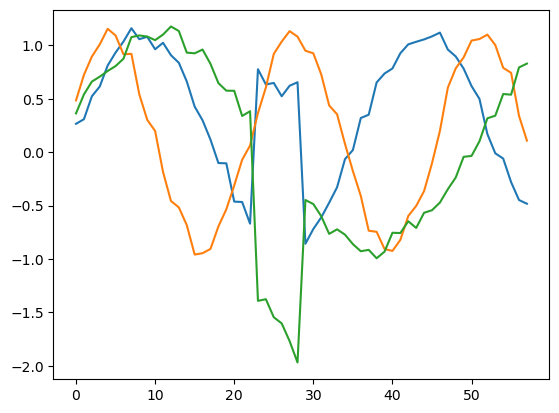

[False False False  True  True]


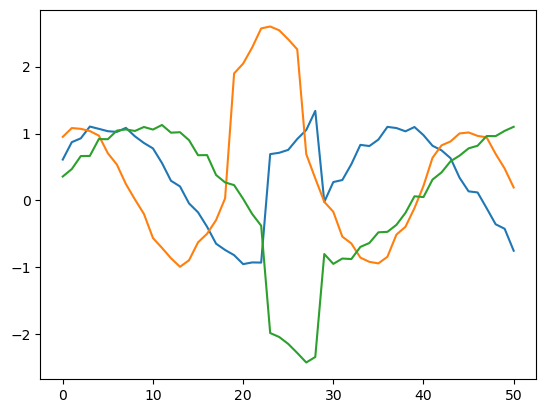

[False False False False False]


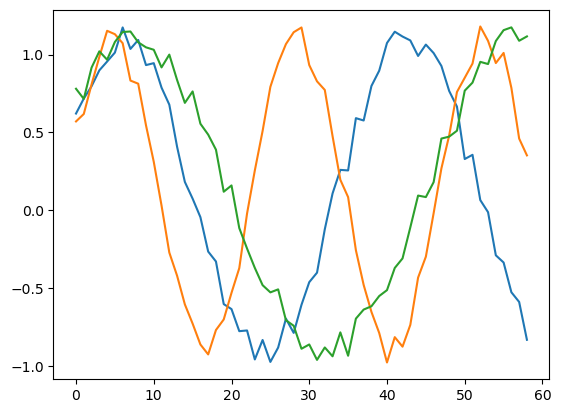

[ True False False False  True]


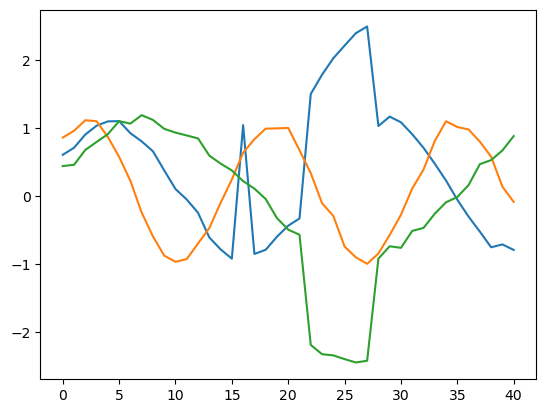

[False  True False False False]


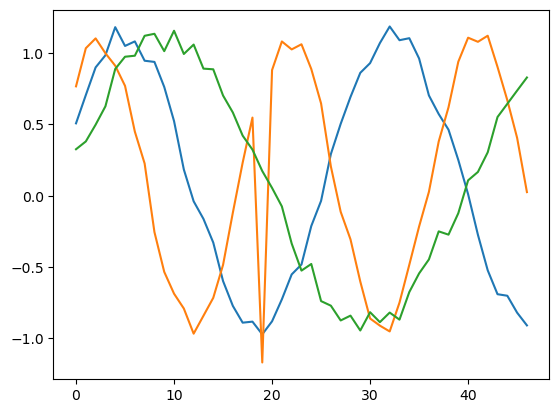

In [7]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

# Classification

## Preprocessing 
 
#### Making samples of the same length

In [8]:
print(f'All unique lengths: {set(map(len, xl))}')

All unique lengths: {40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}


In [9]:
## True/False => 1/0
yl_prep = np.array(yl)
yl_prep = yl_prep.astype(int)
yl_prep.shape

(50000, 5)

### Approach 1: Crop all samples to minimal length
#### **Downside:** We lose some information

In [10]:
min_len = min(map(len, xl))
xl_cut = np.array(list(map(lambda x: x[:min_len], xl)))
xl_cut.shape

(50000, 40, 3)

### Approach 2: Fill all samples with last value to maximal length

<font size="3"> 
    
**Downside:** It creates false pattern at the end of shorter samples
    
**Note:** However, since the length of samples is completely random, this pattern is distributed among all classes similarly

Therefore, it does ***not*** influence the behaviour of the model.
    
</font>

In [11]:
max_len = max(map(len, xl))
fill_func = lambda x: np.pad(x, ((0, max_len-len(x)), (0, 0)), 'edge')
xl_filled = np.array(list(map(fill_func, xl)))
xl_filled.shape

(50000, 59, 3)

# Deep Learning Model

In [12]:
def train_val_test_split(x, y, train_size, val_size):   
    train_split = int(train_size * len(x))
    val_split = int(val_size * len(x))

    x_train = x[:train_split]
    y_train = y[:train_split]

    x_val = x[train_split:val_split]
    y_val = y[train_split:val_split]

    x_test = x[val_split:]
    y_test = y[val_split:]
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [31]:
def get_model(input_shape):
    tf.keras.backend.clear_session()   ## clear all existing models' sessions
    
    model = Sequential([
        BatchNormalization(input_shape=input_shape),
        
        LSTM(256),
        BatchNormalization(),
        Dropout(rate=0.1),

        Dense(5, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['binary_accuracy']
    )
    
    return model

<font size="3">

**Note:** considering [T, F, F, T, T] sample and its prediction [F, F, F, T, T], **default accuracy** is **0**, since they are different ***overall***. 
    
However, **binary accuracy** considers each pattern (T/F) separately, so that the differance with the prediction lowers to **only one error/defect**. 
    
</font>

# Model Training - Approach 1 (Minimal Length)

In [32]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(xl_cut, yl_prep, 0.8, 0.9)

In [33]:
model = get_model(x_train.shape[1:])

early = EarlyStopping(
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True
)

reduce = ReduceLROnPlateau(patience=5)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200, 
    batch_size = 1000, 
    callbacks=[early, reduce]
)

Epoch 1/200
40/40 [==============================] - 3s 45ms/step - loss: 0.4751 - binary_accuracy: 0.7446 - val_loss: 0.6874 - val_binary_accuracy: 0.6042 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 1s 36ms/step - loss: 0.3407 - binary_accuracy: 0.8565 - val_loss: 0.6249 - val_binary_accuracy: 0.5965 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 1s 36ms/step - loss: 0.2978 - binary_accuracy: 0.8848 - val_loss: 0.5574 - val_binary_accuracy: 0.7125 - lr: 0.0010
Epoch 4/200
40/40 [==============================] - 1s 36ms/step - loss: 0.2719 - binary_accuracy: 0.8988 - val_loss: 0.4373 - val_binary_accuracy: 0.8245 - lr: 0.0010
Epoch 5/200
40/40 [==============================] - 1s 36ms/step - loss: 0.2411 - binary_accuracy: 0.9153 - val_loss: 0.3817 - val_binary_accuracy: 0.8582 - lr: 0.0010
Epoch 6/200
40/40 [==============================] - 1s 36ms/step - loss: 0.2270 - binary_accuracy: 0.9225 - val_loss: 0.3405 - val_binary_accuracy: 0.8638

In [38]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 3ms/step - loss: 0.1261 - binary_accuracy: 0.9669


[0.12605470418930054, 0.966920018196106]

In [39]:
pred = np.round(model.predict(x_test))

157/157 [==============================] - 0s 2ms/step


In [40]:
## manual check

score = sum(np.all(pred == y_test, axis=1)) / len(pred)
print(f'Default accuracy: {score}')

score = np.sum(pred == y_test) / (len(pred)*5)
print(f'Binary accuracy: {score}')

Default accuracy: 0.8478
Binary accuracy: 0.96692


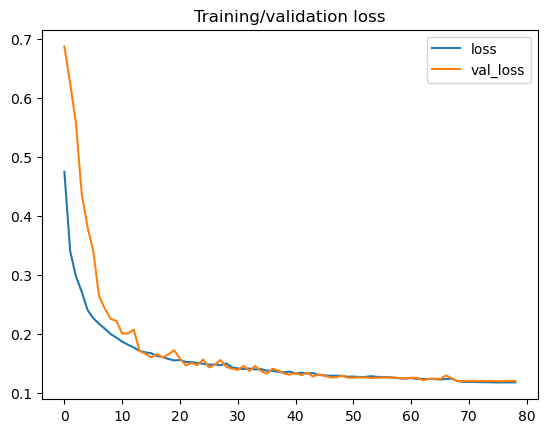

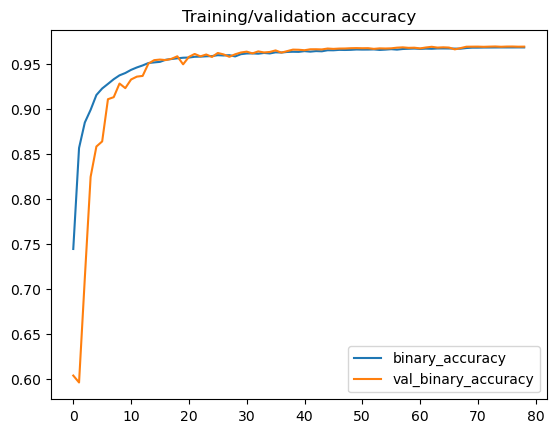

In [42]:
his = pd.DataFrame(history.history)
his[['loss', 'val_loss']].plot(title='Training/validation loss');
his[['binary_accuracy', 'val_binary_accuracy']].plot(title='Training/validation accuracy');

### Run if needed for model to be saved as file

In [44]:
## save model
# model.save('model_1.h5')
## load model
# model = load_model('model_1.h5')

# Model Training - Approach 2 (Maximal Length)

In [45]:
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(xl_filled, yl_prep, 0.8, 0.9)

In [46]:
model = get_model(x_train.shape[1:])

early = EarlyStopping(
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True
)

reduce = ReduceLROnPlateau(patience=5)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200, 
    batch_size = 1000, 
    callbacks=[early, reduce]
)

Epoch 1/200
40/40 [==============================] - 4s 62ms/step - loss: 0.5419 - binary_accuracy: 0.6846 - val_loss: 0.8119 - val_binary_accuracy: 0.6472 - lr: 0.0010
Epoch 2/200
40/40 [==============================] - 2s 53ms/step - loss: 0.3457 - binary_accuracy: 0.8399 - val_loss: 0.7481 - val_binary_accuracy: 0.6934 - lr: 0.0010
Epoch 3/200
40/40 [==============================] - 2s 52ms/step - loss: 0.2800 - binary_accuracy: 0.8784 - val_loss: 0.4904 - val_binary_accuracy: 0.7661 - lr: 0.0010
Epoch 4/200
40/40 [==============================] - 2s 52ms/step - loss: 0.2549 - binary_accuracy: 0.8922 - val_loss: 0.4645 - val_binary_accuracy: 0.7896 - lr: 0.0010
Epoch 5/200
40/40 [==============================] - 2s 52ms/step - loss: 0.2793 - binary_accuracy: 0.8810 - val_loss: 0.3741 - val_binary_accuracy: 0.8489 - lr: 0.0010
Epoch 6/200
40/40 [==============================] - 2s 52ms/step - loss: 0.2403 - binary_accuracy: 0.8972 - val_loss: 0.2951 - val_binary_accuracy: 0.8754

In [47]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 1s 3ms/step - loss: 0.0180 - binary_accuracy: 0.9944


[0.01795610971748829, 0.9944401383399963]

In [48]:
pred = np.round(model.predict(x_test))

157/157 [==============================] - 1s 2ms/step


In [49]:
## manual check

score = sum(np.all(pred == y_test, axis=1)) / len(pred)
print(f'Default accuracy: {score}')

score = np.sum(pred == y_test) / (len(pred)*5)
print(f'Binary accuracy: {score}')

Default accuracy: 0.9724
Binary accuracy: 0.99444


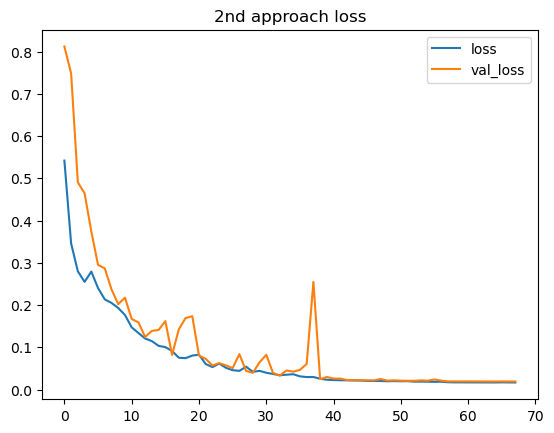

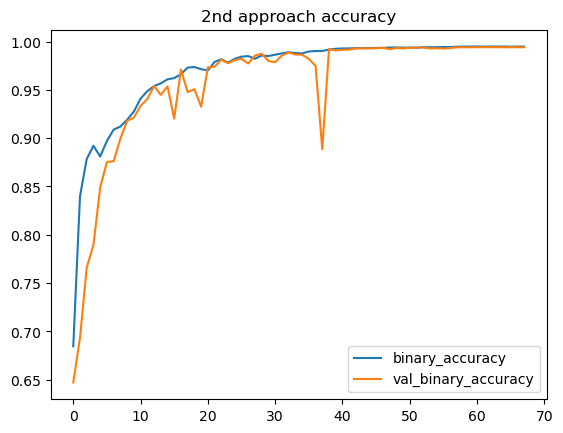

In [50]:
his = pd.DataFrame(history.history)
his[['loss', 'val_loss']].plot(title='2nd approach loss');
his[['binary_accuracy', 'val_binary_accuracy']].plot(title='2nd approach accuracy');

### Run if needed for model to be saved as file

In [51]:
## save model
# model.save('model_2.h5')
## load model
# model = load_model('model_2.h5')

## Loss Functions Conclusions

<font size="3">

- Both approaches converge (proving the correctness of the model)

- Approach 2 (Maximal Length) leads to much higher both default and binary accuracies (as expected):

    - Approach 1: Default accuracy: 0.8478; Binary accuracy: 0.96692

    - Approach 2: Default accuracy : 0.9724; Binary accuracy: 0.99444
    
Therefore, Approach 2 is used further.
    
</font>    

# Anomaly Pattern Detection

<font size="3">

The Anomaly Pattern Detection is performed using Autoencoder by training the collection of samples with no defects.

This way decoded recreated input based on encoded latent representation is clean or defectless, so that in comparison to them the anomalies are somewhat outliers on the episodes of a defect.
    
</font>

In [132]:
## collect all samples with one or no defects
collection = {}
for i, j in zip(xl_filled, yl_prep):
    if sum(j) in [0, 1]:
        collection.setdefault(tuple(j), []).append(i)
print(*list(collection.keys()))

(0, 0, 0, 0, 1) (0, 0, 0, 0, 0) (0, 1, 0, 0, 0) (1, 0, 0, 0, 0) (0, 0, 0, 1, 0) (0, 0, 1, 0, 0)


In [53]:
x_train = np.array(collection[(0, 0, 0, 0, 0)])
x_train.shape

(11723, 59, 3)

In [55]:
tf.keras.backend.clear_session()   ## clear all existing models' sessions
encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=x_train.shape[1:]),
    LSTM(16, return_sequences=True),
    LSTM(8)
])

decoder = Sequential([
    RepeatVector(x_train.shape[1]),
    LSTM(16, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(3))
])

model = Sequential([
    encoder,
    decoder
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [56]:
early = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True,
)

reduce = ReduceLROnPlateau(monitor='loss', patience=5)

history = model.fit(
    x_train, x_train,
    validation_batch_size=(x_train, x_train),
    epochs=1000, 
    batch_size = 500, 
    callbacks=[early, reduce]
)

Epoch 1/1000
24/24 [==============================] - 6s 20ms/step - loss: 0.5072 - mae: 0.6339 - lr: 0.0010
Epoch 2/1000
24/24 [==============================] - 0s 18ms/step - loss: 0.4118 - mae: 0.5482 - lr: 0.0010
Epoch 3/1000
24/24 [==============================] - 0s 18ms/step - loss: 0.2810 - mae: 0.4305 - lr: 0.0010
Epoch 4/1000
24/24 [==============================] - 0s 19ms/step - loss: 0.1556 - mae: 0.2998 - lr: 0.0010
Epoch 5/1000
24/24 [==============================] - 0s 20ms/step - loss: 0.1046 - mae: 0.2429 - lr: 0.0010
Epoch 6/1000
24/24 [==============================] - 0s 19ms/step - loss: 0.0755 - mae: 0.2028 - lr: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 19ms/step - loss: 0.0595 - mae: 0.1821 - lr: 0.0010
Epoch 8/1000
24/24 [==============================] - 0s 20ms/step - loss: 0.0496 - mae: 0.1682 - lr: 0.0010
Epoch 9/1000
24/24 [==============================] - 0s 19ms/step - loss: 0.0438 - mae: 0.1598 - lr: 0.0010
Epoch 10/1000
24/24

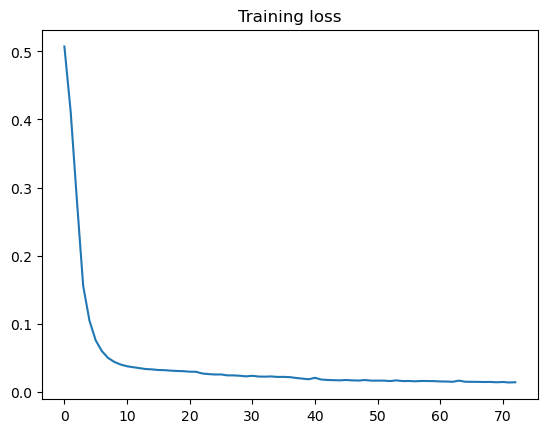

In [62]:
his = pd.DataFrame(history.history)['loss'].plot(title='Training loss')

### Run if needed for model to be saved as file

In [64]:
## save model
# model.save('model_3.h5')
## load model
# model = load_model('model_2.h5')

In [433]:
def find_anomaly(key, sample):
    sample_pred = model.predict(np.array([sample]))[0]
    defect = np.where(abs(sample - sample_pred) > np.std(sample_pred))

    defect_split = []
    left = 0
    for i in np.where(np.diff(defect[0]) > 1)[0]:
        right = i + 1
        defect_split.append(defect[0][left:right])
        left = right
    defect_split.append(defect[0][left:])
            
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(sample)
    plt.plot(sample_pred, '--', color='r')
    plt.gca().legend(tuple([f"sensor {x}" for x in range(len(sample[0]))]))
    
    if len(defect[0]):
        print(f'\nDefect of type {key.astype(bool)}, occured at sensors: {set(defect[1])}')
        for i in defect_split:
            plt.axvspan(i[0]-1, i[-1]+1, facecolor='r', alpha=0.2)
    else:
        print(f'No defect here, of it is equivalent to noise')
        
    plt.show()
    print('\n\n\n\n')

## Detection of each defect separately

1/1 [==============================] - 0s 19ms/step

Defect of type [False False False False  True], occured at sensors: {0, 2}


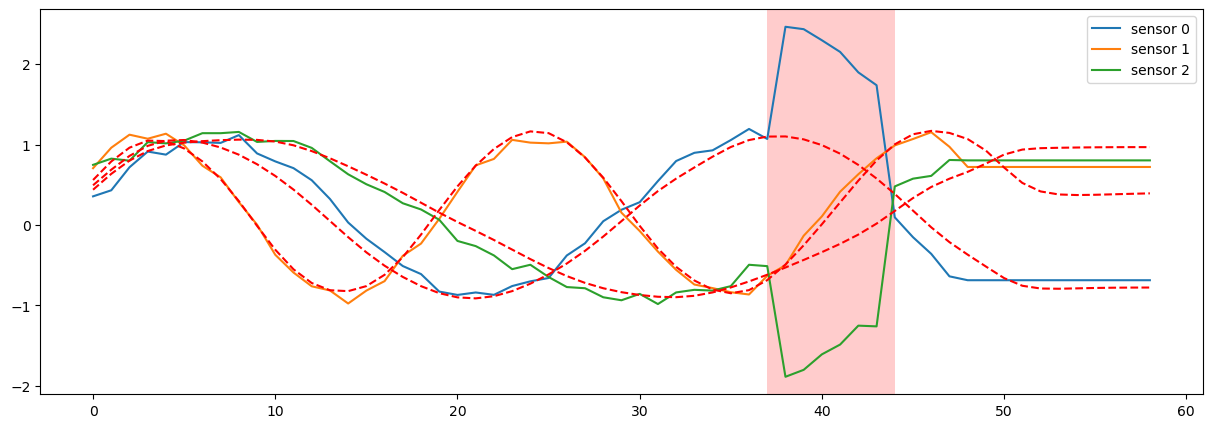






1/1 [==============================] - 0s 17ms/step

Defect of type [False  True False False False], occured at sensors: {1}


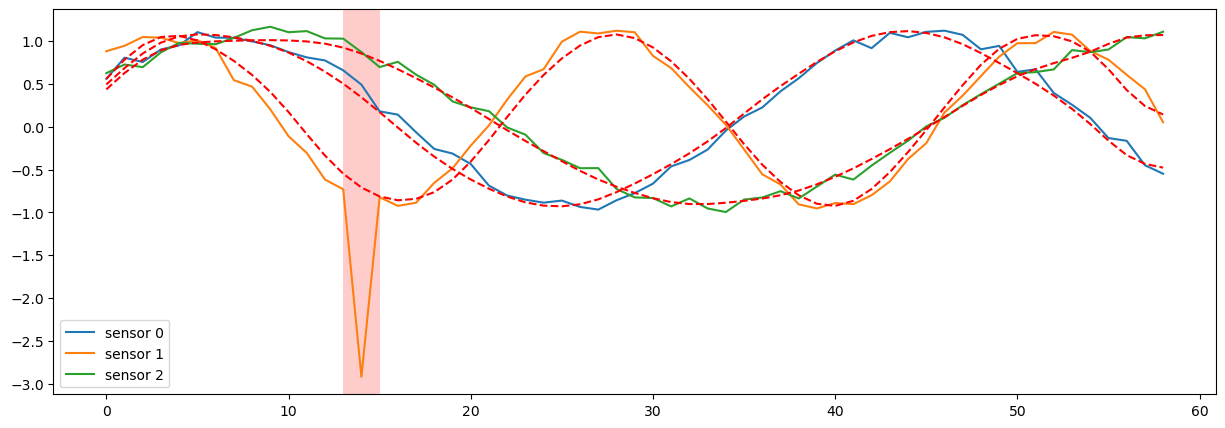






1/1 [==============================] - 0s 17ms/step

Defect of type [ True False False False False], occured at sensors: {0}


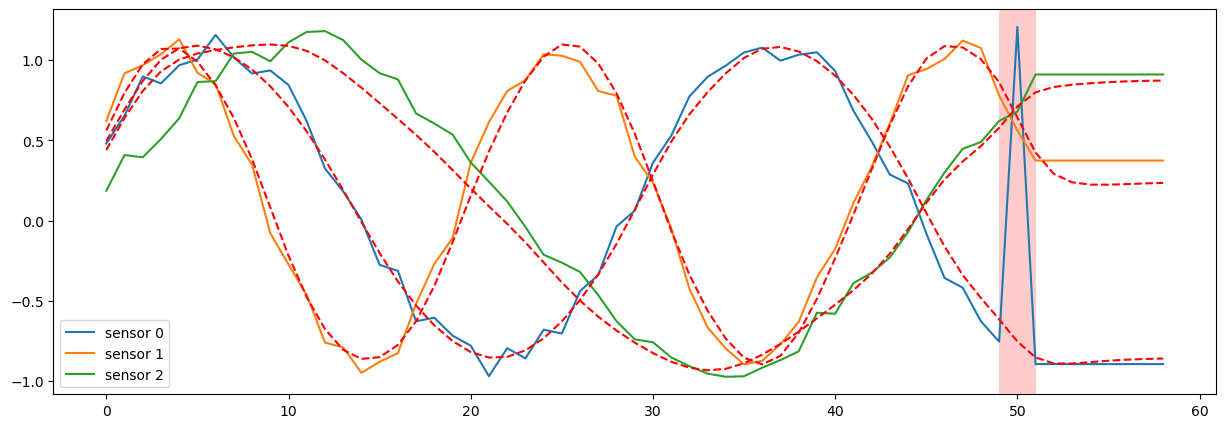






1/1 [==============================] - 0s 19ms/step

Defect of type [False False False  True False], occured at sensors: {1}


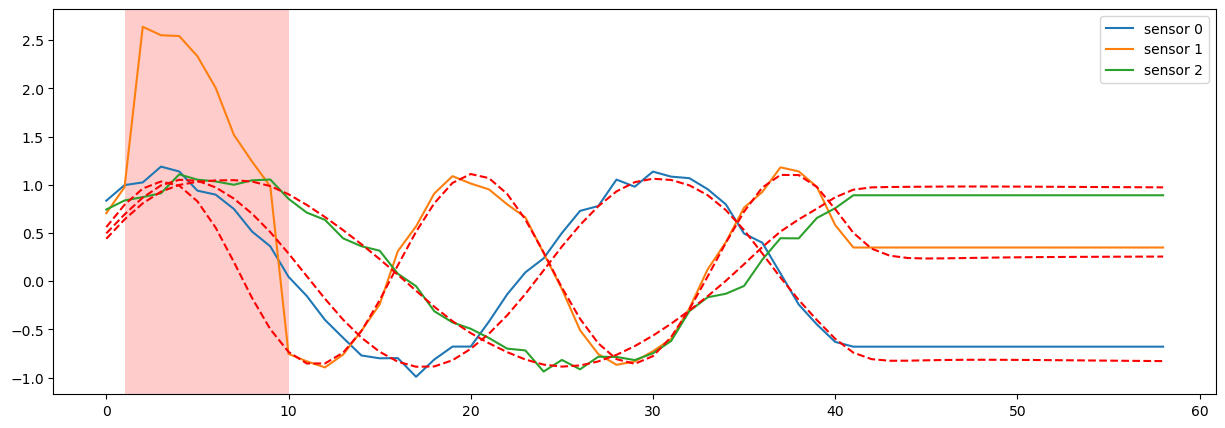






1/1 [==============================] - 0s 16ms/step

Defect of type [False False  True False False], occured at sensors: {2}


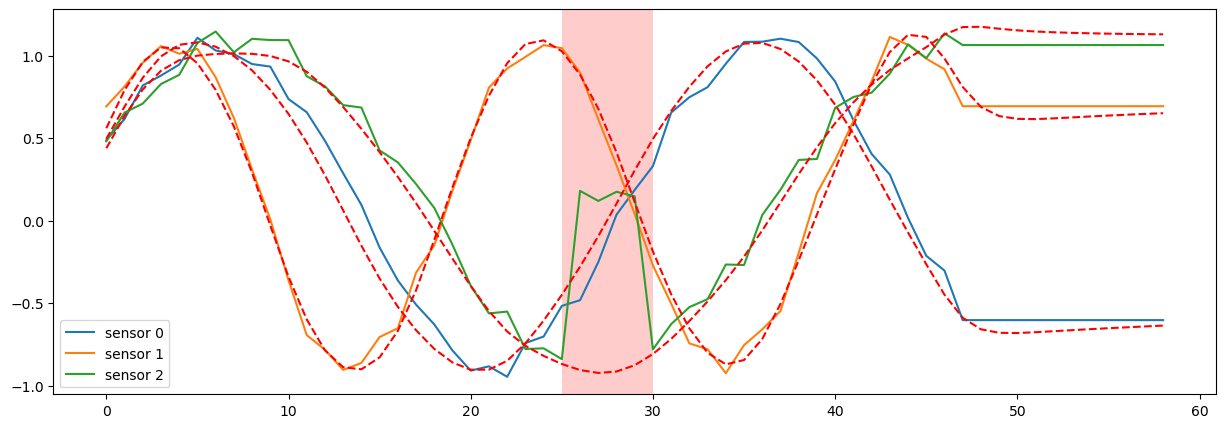

In [434]:
np.random.seed(1234)

for key, value in collection.items():
    if sum(key):
        sample = value[np.random.randint(0, len(value)-1)]
        find_anomaly(np.array(key), sample)

### Concrete rules obtained:

<font size="3">
    
- sensor 2 zeroes <=> the 2nd element is defected

- spike up of sensor 1 <=> the 3rd element is defected

- spike up of sensor 0 <=> the 0th element is defected

- spike down of sensor 1 <=> the 1st element is defected

- spike up of sensor 0 and spike down of sensor 2 simultaneously <=> the 4th element is defected
    
</font>

## Detection of multiple defects

1/1 [==============================] - 0s 18ms/step

Defect of type [False False False  True  True], occured at sensors: {0, 1, 2}


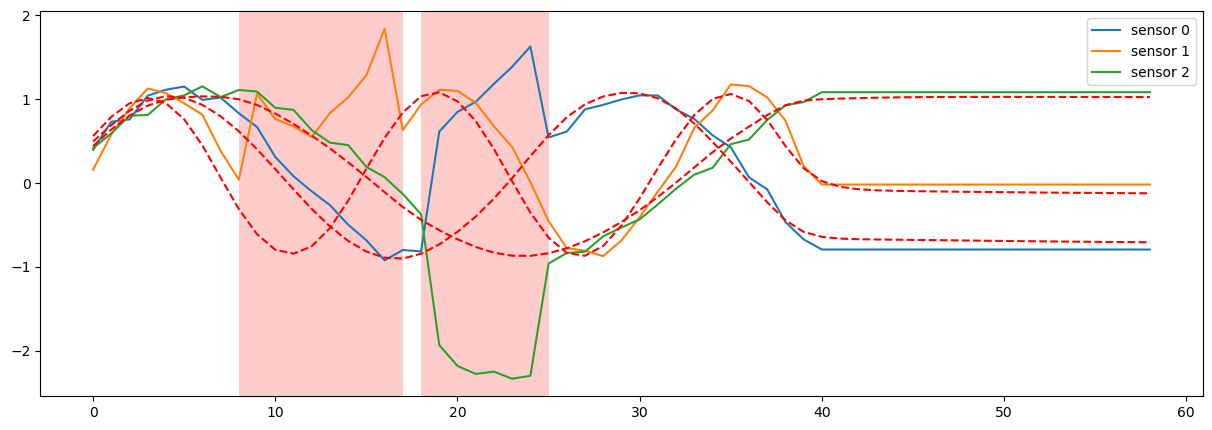






1/1 [==============================] - 0s 20ms/step

Defect of type [False  True  True False False], occured at sensors: {1, 2}


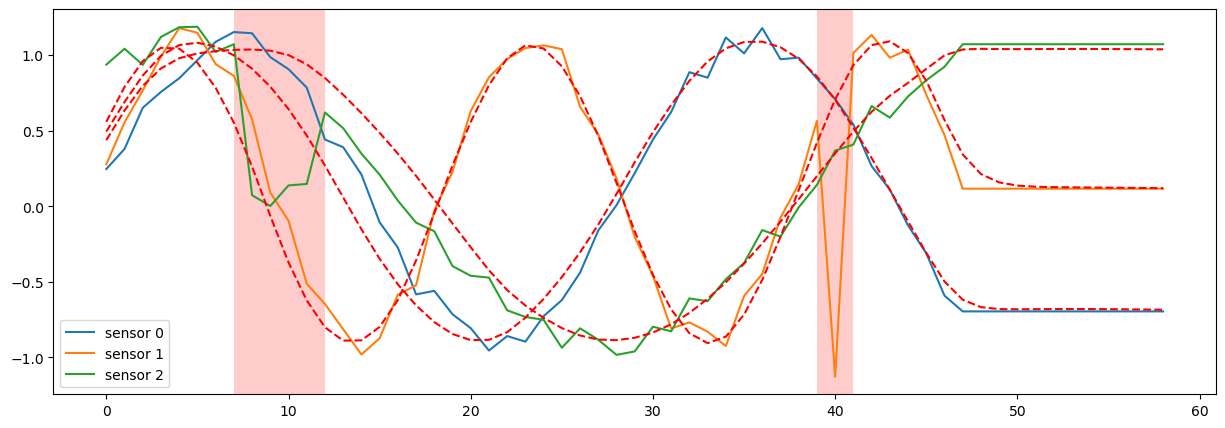






1/1 [==============================] - 0s 18ms/step

Defect of type [False  True  True False False], occured at sensors: {1, 2}


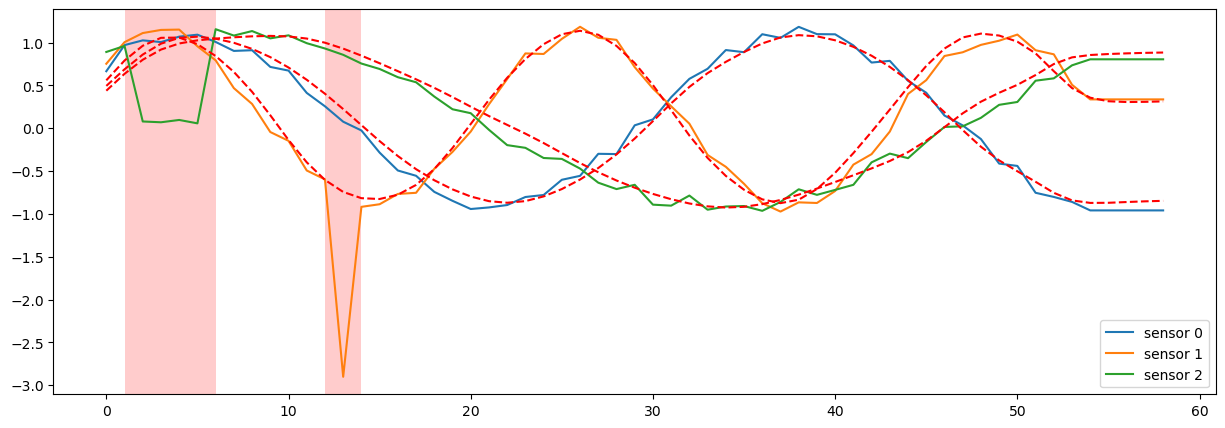






1/1 [==============================] - 0s 21ms/step

Defect of type [ True False False False  True], occured at sensors: {0, 2}


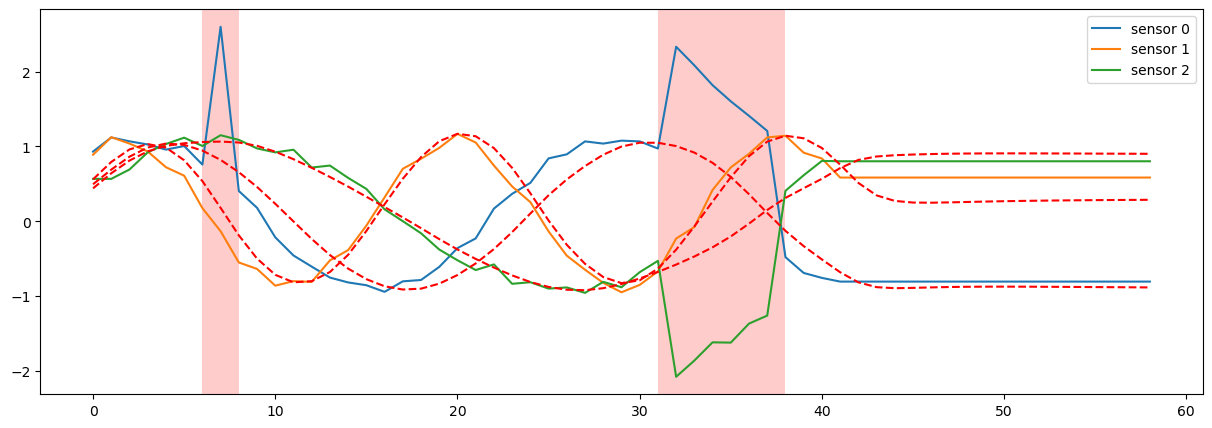






1/1 [==============================] - 0s 19ms/step

Defect of type [ True False  True False  True], occured at sensors: {0, 2}


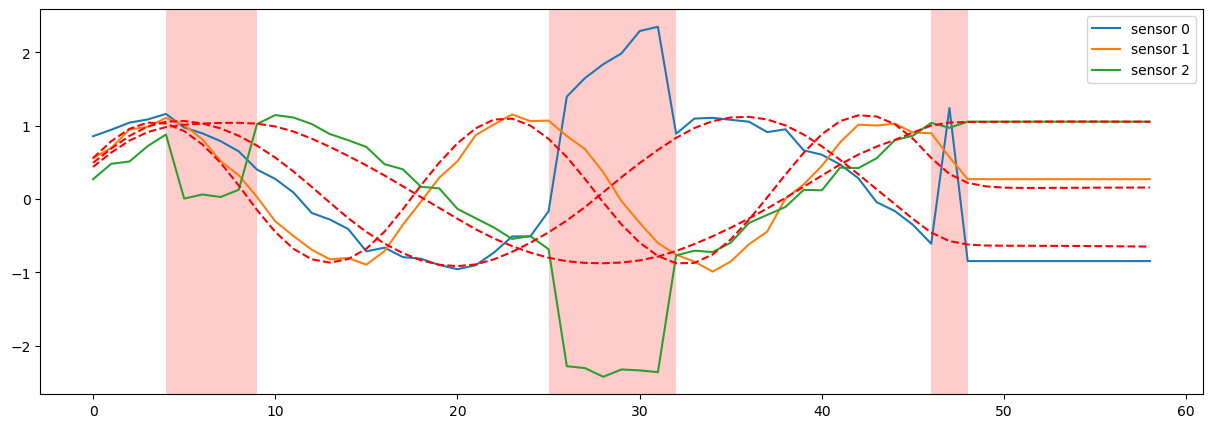

In [438]:
more_than_one = np.where(np.sum(yl_prep, axis=1) > 1)[0]
for i in range(5):
    idx = more_than_one[np.random.randint(0, len(more_than_one)-1)]
    find_anomaly(yl_prep[idx], xl_filled[idx])

<font size="3">

Perfomed anomaly recognition allows us to detect when a candy is defected.

Such plots give us all the necessary information to get what causes a defect:

- each pattern related to a defect is highlighed on the plots

- a color corresponds to a sensor

- the corresponding to the defects sensors are mentioned next to the data sample above each plot

</font>